In [5]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# For example, here's several helpful packages to load in 

from subprocess import check_output

train_data = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
test_data = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")

X_train = train_data.iloc[:,1:].values
Y_train = train_data.label.values

X_test = test_data.iloc[:,1:].values
Y_test = test_data.label.values

print(X_test.shape, X_train.shape)


(10000, 784) (60000, 784)


[35831 14669 50769 54053 16131 57357 58770 51357]


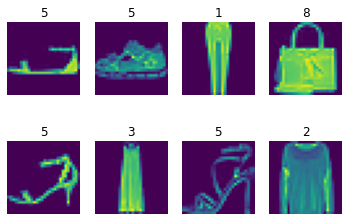

In [7]:
#lets visualize few images 
sample = np.random.randint(0,high= 59999, size=8)
print(sample)
sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()

In [8]:
#Defining constants
epochs = 200
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [10]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [11]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [12]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

/kaggle/working/saved_model/fmnist_resnet_model.h5


In [13]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Not using data augmentation.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 41s 686us/step - loss: 1.2137 - accuracy: 0.8498 - val_loss: 0.9526 - val_accuracy: 0.8634

Epoch 00001: val_loss improved from inf to 0.95261, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 2/200
60000/60000 [==============================] - 31s 522us/step - loss: 0.7739 - accuracy: 0.8954 - val_loss: 0.7979 - val_accuracy: 0.8628

Epoch 00002: val_loss improved from 0.95261 to 0.79792, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 3/200
60000/60000 [==============================] - 31s 512us/step - loss: 0.5995 - accuracy: 0.9089 - val_loss: 0.5612 - val_accuracy: 0.9078

Epoch 00003: val_loss improved from 0.79792 to 0.56121, saving model to /kaggle/working/saved_model/fmnist_resnet_model.h5
Epoch 4/200
60000/60000 [==============================] - 31s 518us/step - loss: 0.5080 - accuracy: 0.

60000/60000 [==============================] - 31s 512us/step - loss: 0.0876 - accuracy: 1.0000 - val_loss: 0.7748 - val_accuracy: 0.9223

Epoch 00038: val_loss did not improve from 0.42134
Epoch 39/200
60000/60000 [==============================] - 31s 515us/step - loss: 0.0851 - accuracy: 0.9999 - val_loss: 0.6970 - val_accuracy: 0.9207

Epoch 00039: val_loss did not improve from 0.42134
Epoch 40/200
60000/60000 [==============================] - 30s 506us/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.7395 - val_accuracy: 0.9207

Epoch 00040: val_loss did not improve from 0.42134
Epoch 41/200
60000/60000 [==============================] - 31s 519us/step - loss: 0.0832 - accuracy: 1.0000 - val_loss: 0.7681 - val_accuracy: 0.9206

Epoch 00041: val_loss did not improve from 0.42134
Epoch 42/200
60000/60000 [==============================] - 31s 513us/step - loss: 0.0825 - accuracy: 1.0000 - val_loss: 0.8082 - val_accuracy: 0.9215

Epoch 00042: val_loss did not improve from 0.4213

60000/60000 [==============================] - 31s 510us/step - loss: 0.0635 - accuracy: 1.0000 - val_loss: 0.9192 - val_accuracy: 0.9209

Epoch 00118: val_loss did not improve from 0.42134
Epoch 119/200
60000/60000 [==============================] - 31s 517us/step - loss: 0.0634 - accuracy: 1.0000 - val_loss: 0.9203 - val_accuracy: 0.9210

Epoch 00119: val_loss did not improve from 0.42134
Epoch 120/200
60000/60000 [==============================] - 31s 511us/step - loss: 0.0632 - accuracy: 1.0000 - val_loss: 0.9218 - val_accuracy: 0.9210

Epoch 00120: val_loss did not improve from 0.42134
Epoch 121/200
60000/60000 [==============================] - 31s 513us/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.9218 - val_accuracy: 0.9207

Epoch 00121: val_loss did not improve from 0.42134
Epoch 122/200
60000/60000 [==============================] - 31s 510us/step - loss: 0.0628 - accuracy: 1.0000 - val_loss: 0.9226 - val_accuracy: 0.9210

Epoch 00122: val_loss did not improve from 0.

60000/60000 [==============================] - 30s 506us/step - loss: 0.0530 - accuracy: 1.0000 - val_loss: 0.9071 - val_accuracy: 0.9214

Epoch 00198: val_loss did not improve from 0.42134
Epoch 199/200
60000/60000 [==============================] - 31s 521us/step - loss: 0.0529 - accuracy: 1.0000 - val_loss: 0.9071 - val_accuracy: 0.9210

Epoch 00199: val_loss did not improve from 0.42134
Epoch 200/200
60000/60000 [==============================] - 30s 504us/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 0.9045 - val_accuracy: 0.9205

Epoch 00200: val_loss did not improve from 0.42134


In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



10000/10000 [==============================] - 3s 333us/step
Test loss: 0.9044791375160217
Test accuracy: 0.9204999804496765
